In [14]:
!pip list

Package           Version
----------------- -----------
appnope           0.1.4
asttokens         2.4.1
comm              0.2.2
contourpy         1.2.1
cycler            0.12.1
debugpy           1.8.2
decorator         5.1.1
executing         2.0.1
fonttools         4.53.1
ipykernel         6.29.5
ipython           8.26.0
jedi              0.19.1
joblib            1.4.2
jupyter_client    8.6.2
jupyter_core      5.7.2
kiwisolver        1.4.5
matplotlib        3.9.1
matplotlib-inline 0.1.7
nest-asyncio      1.6.0
numpy             2.0.0
packaging         24.1
pandas            2.2.2
parso             0.8.4
pexpect           4.9.0
pillow            10.4.0
pip               24.1.2
platformdirs      4.2.2
prompt_toolkit    3.0.47
psutil            6.0.0
ptyprocess        0.7.0
pure-eval         0.2.2
Pygments          2.18.0
pyparsing         3.1.2
python-dateutil   2.9.0.post0
pytz              2024.1
pyzmq             26.0.3
scikit-learn      1.5.1
scipy             1.14.0
seaborn        

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

##  Data Exploration

In [15]:
index_data =pd.read_csv('indexData.csv')
index_info = pd.read_csv('indexInfo.csv')
index_processed = pd.read_csv('indexProcessed.csv')

# print(index_data)
# print(index_info)
# print(index_processed)
# print(index_data.describe())
index_data['Date'] = pd.to_datetime(index_data['Date'])
# plt.figure(figsize=(12, 6))

## Data Cleaning

Index           0
Date            0
Open         2204
High         2204
Low          2204
Close        2204
Adj Close    2204
Volume       2204
dtype: int64
Remaining missing values in indexData: Index           0
Date            0
Open         2204
High         2204
Low          2204
Close        2204
Adj Close    2204
Volume       2204
dtype: int64
Duplicates in indexData: 0
Duplicates in indexProcessed: 0


/var/folders/g9/2kyzp3bj38lf2zr6mxb31v540000gn/T/ipykernel_46309/3060280187.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  index_data['Volume'].replace(0, index_data['Volume'].mean(), inplace=True)
/var/folders/g9/2kyzp3bj38lf2zr6mxb31v540000gn/T/ipykernel_46309/3060280187.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which 

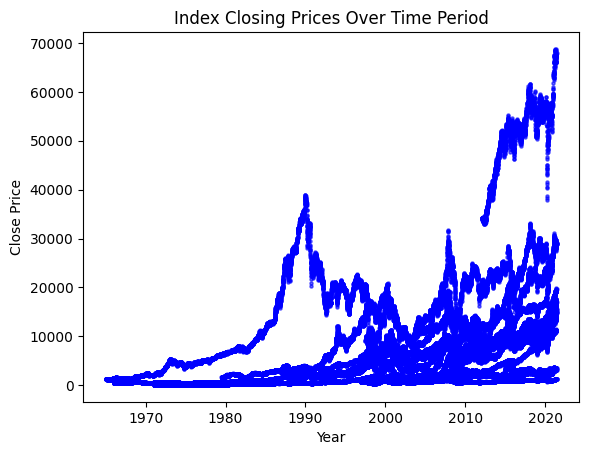

In [16]:
# Checking for any remaining missing values
remaining_missing_values_index_data = index_data.isnull().sum()
print(remaining_missing_values_index_data)

# Handling zero volumes (assuming they represent missing data)
index_data['Volume'].replace(0, index_data['Volume'].mean(), inplace=True)
index_processed['Volume'].replace(0, index_processed['Volume'].mean(), inplace=True)

# Checking for duplicates
duplicates_index_data = index_data.duplicated().sum()
duplicates_index_processed = index_processed.duplicated().sum()

print("Remaining missing values in indexData:", remaining_missing_values_index_data)
print("Duplicates in indexData:", duplicates_index_data)
print("Duplicates in indexProcessed:", duplicates_index_processed)

plt.scatter(index_data['Date'], index_data['Close'], s=5, c='blue', alpha=0.6)  
plt.title('Index Closing Prices Over Time Period')
plt.xlabel('Year')
plt.ylabel('Close Price')
plt.show()



##  Feature Engineering

###  lag feature

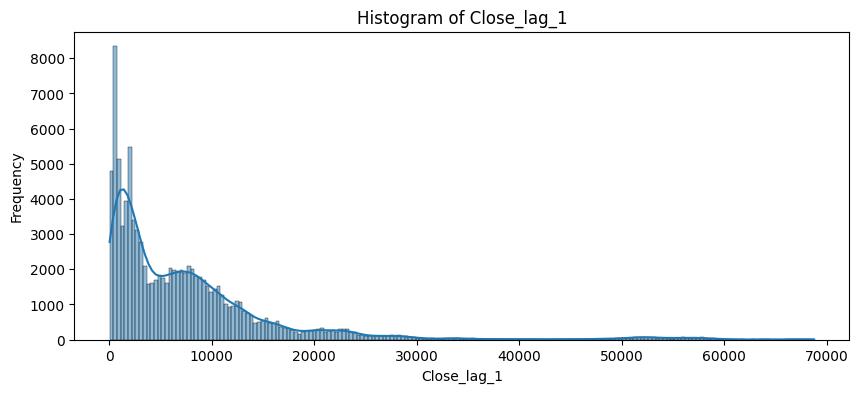

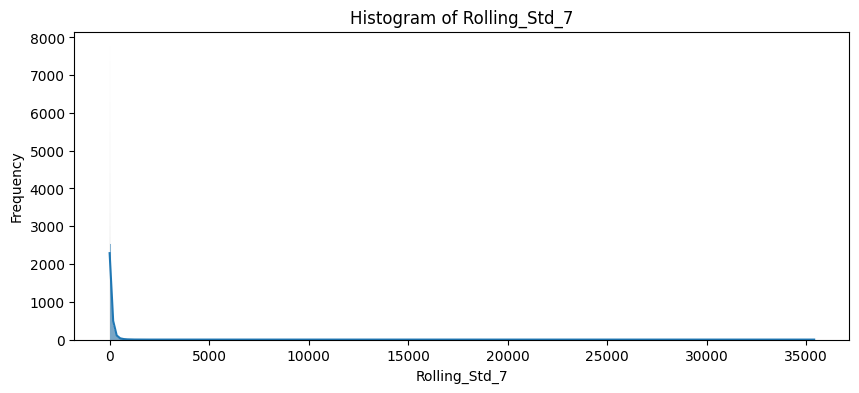

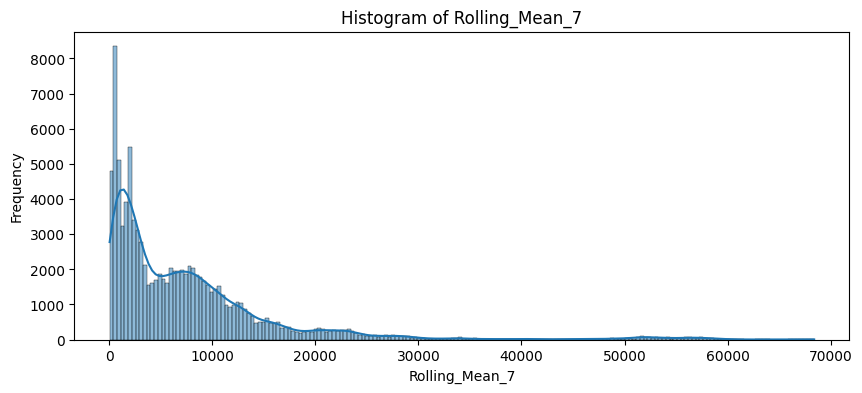

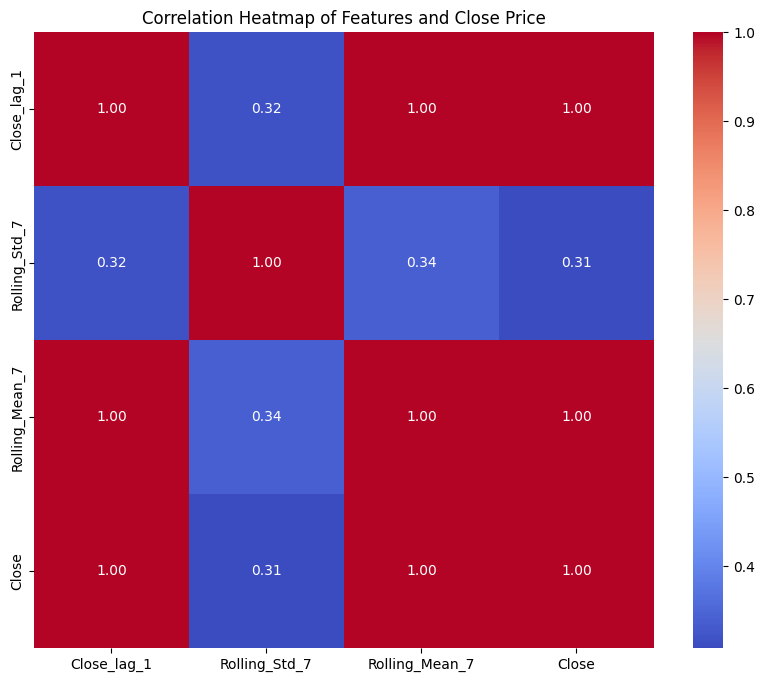

In [17]:
# Extract date features
index_data['Year'] = index_data['Date'].dt.year
index_data['Month'] = index_data['Date'].dt.month
index_data['Day'] = index_data['Date'].dt.day
index_data['DayOfWeek'] = index_data['Date'].dt.dayofweek  # Monday=0, Sunday=6

# Create lag features
for lag in [1, 7, 30]:  # Lag of 1 day, 1 week, and 1 month
    index_data[f'Close_lag_{lag}'] = index_data['Close'].shift(lag)

# Moving average and rolling window features
index_data['Rolling_Mean_7'] = index_data['Close'].rolling(window=7).mean()
index_data['Rolling_Std_7'] = index_data['Close'].rolling(window=7).std()

# Difference features
index_data['Daily_Change'] = index_data['Close'].diff()

# Example of a simple indicator feature
index_data['Significant_High'] = (index_data['High'] > index_data['High'].shift(1) * 1.05).astype(int)

# Drop any rows with NaN values created by shifts and rolling features
index_data.dropna(inplace=True)

# Save or preview the data
index_data.to_csv('feature_engineered_data.csv', index=False)
index_data.head()

# Plotting histograms for each feature
features = ['Close_lag_1', 'Rolling_Std_7', 'Rolling_Mean_7']
for feature in features:
    plt.figure(figsize=(10, 4))
    sns.histplot(index_data[feature], kde=True)
    plt.title(f'Histogram of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.show()

# Correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(index_data[features + ['Close']].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of Features and Close Price')
plt.show()

## Modelling

For each model below, please rerun the above code to ensure the input data is correct / avoid variable name conflict.

###KNN - Apply kNN Model, scaling features is critical to ensure that one feature doesn’t dominate the distance metric due to its scale.

In [18]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X = index_data[['Close_lag_1', 'Close_lag_7', 'Close_lag_30', 'Rolling_Mean_7', 'Rolling_Std_7', 'Daily_Change', 'Significant_High']]
target = index_data['Close']

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, target, test_size=0.2, random_state=42)

# Standardize features (important for k-NN)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### KNN - train KNN model using the training data

In [8]:
from sklearn.neighbors import KNeighborsRegressor

# Initialize the k-NN model
knn = KNeighborsRegressor(n_neighbors=5, metric='euclidean')

# Train the model
knn.fit(X_train_scaled, y_train)

KNeighborsRegressor(metric='euclidean')

### KNN - Model Evaluation

In [9]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Predicting the test set results
y_pred = knn.predict(X_test_scaled)

# Calculating RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# Calculating R^2
r_squared = r2_score(y_test, y_pred)

# Printing the results
print(f"RMSE: {rmse}")
print(f"R^2: {r_squared}")

RMSE: 273.1390356451318
R^2: 0.9990838249485683


### KNN - Model Tuning and Validation

In [10]:
from sklearn.model_selection import GridSearchCV

# Setting up the parameter grid
param_grid = {'n_neighbors': [3, 5, 7, 10],
              'weights': ['uniform', 'distance'],
              'metric': ['euclidean', 'manhattan']}

# Using grid search to find the optimal parameters
grid_search = GridSearchCV(KNeighborsRegressor(), param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train_scaled, y_train)

# Best parameters
print("Best parameters:", grid_search.best_params_)

Best parameters: {'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'distance'}


### KNN - Final Evaluation

In [11]:
from sklearn.metrics import mean_squared_error, r2_score
# Train and evaluate the model with the best parameters
best_knn = KNeighborsRegressor(**grid_search.best_params_)
best_knn.fit(X_train_scaled, y_train)
y_pred_best = best_knn.predict(X_test_scaled)
rmse_best = np.sqrt(mean_squared_error(y_test, y_pred_best))
print(f"Improved RMSE: {rmse_best}")

# Calculating R-squared
r2_best = r2_score(y_test, y_pred_best)
print(f"R^2: {r2_best}")

Improved RMSE: 197.74566821067202
R^2: 0.9995197969931583


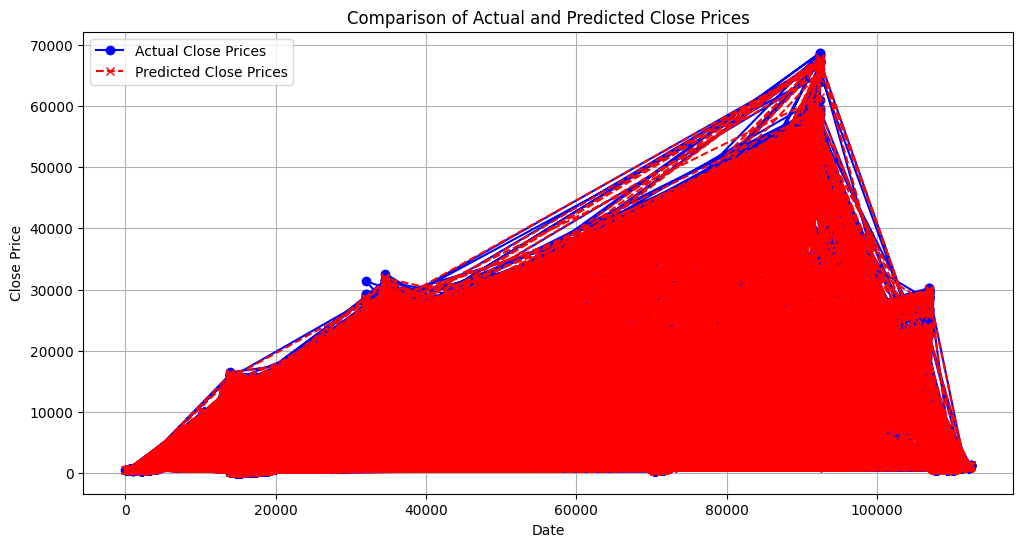

In [12]:
import matplotlib.pyplot as plt

# Plot settings
plt.figure(figsize=(12, 6)) 
plt.plot(y_test.index, y_test, label='Actual Close Prices', color='blue', marker='o')  # Actual values
plt.plot(y_test.index, y_pred, label='Predicted Close Prices', color='red', linestyle='--', marker='x')  # Predictions

plt.title('Comparison of Actual and Predicted Close Prices')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()

plt.grid(True)
plt.show()

### SVM model

In [13]:
# Selecting features and target

import pandas as pd
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

data = pd.read_csv('feature_engineered_data.csv')

# Define the features and target
X = index_data[['Close_lag_1', 'Close_lag_7', 'Close_lag_30', 'Rolling_Mean_7', 'Rolling_Std_7', 'Daily_Change', 'Significant_High']]
y = data['Close']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# Normalize the feature data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize and train the SVM regressor
svm_regressor = SVR(kernel='rbf', C=1.0, gamma='scale')
svm_regressor.fit(X_train_scaled, y_train)

# Predict on the test set
y_pred = svm_regressor.predict(X_test_scaled)



### SVM - Model Evaluation


In [14]:
from sklearn.metrics import mean_squared_error

# Evaluate the model's performance
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print the evaluation results
print(f'MSE: {mse}')
print(f'R^2: {r2}')

Mean Squared Error: 42623345.315592684
R^2 Score: 0.4765701928185321


### SVM - Model Tuning

Grid Search is a method to perform hyperparameter tuning in order to determine the optimal values for a given model. 
grid search with cross-validation to explore multiple combinations of parameters and find the optimal settings.

In [16]:
import pandas as pd
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler

# Load your dataset
data = pd.read_csv('feature_engineered_data.csv')

# Drop rows with NaN values if necessary
data = data.dropna()

# Define the features and target
X = data[['Close_lag_1', 'Close_lag_7', 'Close_lag_30', 'Rolling_Mean_7', 'Rolling_Std_7', 'Daily_Change', 'Significant_High']]
y = data['Close']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# Normalize the feature data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Set up the parameter grid to tune the SVM parameters
param_grid = {
    'C': [0.1, 1, 10],  # Regularization parameter
    'gamma': ['scale', 'auto', 0.1, 1],  # Kernel coefficient for 'rbf', 'poly' and 'sigmoid'
    'kernel': ['rbf', 'linear', 'poly']  # Type of SVM kernel
}

# Initialize the SVM regressor
svm_regressor = SVR()

# Create the GridSearchCV object
grid_search = GridSearchCV(estimator=svm_regressor, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', verbose=2)

# Fit GridSearchCV
grid_search.fit(X_train_scaled, y_train)

# Best parameters and best score
best_parameters = grid_search.best_params_
best_score = grid_search.best_score_

# Print the best parameters and best score
print(f'Best parameters: {best_parameters}')
print(f'Best score: {best_score}')
print(f"Best cross-validation RMSE: {best_score}")

Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time= 2.7min
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time= 2.8min
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time= 2.7min
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time= 2.7min
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time= 2.9min
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time= 8.4min
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time= 8.0min
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time= 7.8min
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time= 9.9min
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=12.0min
[CV] END ....................C=0.1, gamma=scale, kernel=poly; total time= 2.2min
[CV] END ....................C=0.1, gamma=scale

### SVM - Final model Evaluation

In [79]:
import pandas as pd
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

# Load your dataset
data = pd.read_csv('feature_engineered_data.csv')

# Drop rows with NaN values if necessary
data = data.dropna()

# Define the features and target
X = data[['Close_lag_1', 'Close_lag_7', 'Close_lag_30', 'Rolling_Mean_7', 'Rolling_Std_7', 'Daily_Change', 'Significant_High']]
y = data['Close']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# Normalize the feature data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Assuming best_parameters are obtained from your GridSearchCV
best_parameters = {'C': 1, 'kernel': 'rbf', 'gamma': 'scale'}

# Initialize the SVM regressor with the best parameters
final_svm_regressor = SVR(**best_parameters)

# Train the final SVM model
final_svm_regressor.fit(X_train_scaled, y_train)

# Predict on the test set
y_pred = final_svm_regressor.predict(X_test_scaled)

# Evaluate the final model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print the evaluation results
print(f'Final Model Mean Squared Error: {mse}')
print(f'Final Model R^2 Score: {r2}')

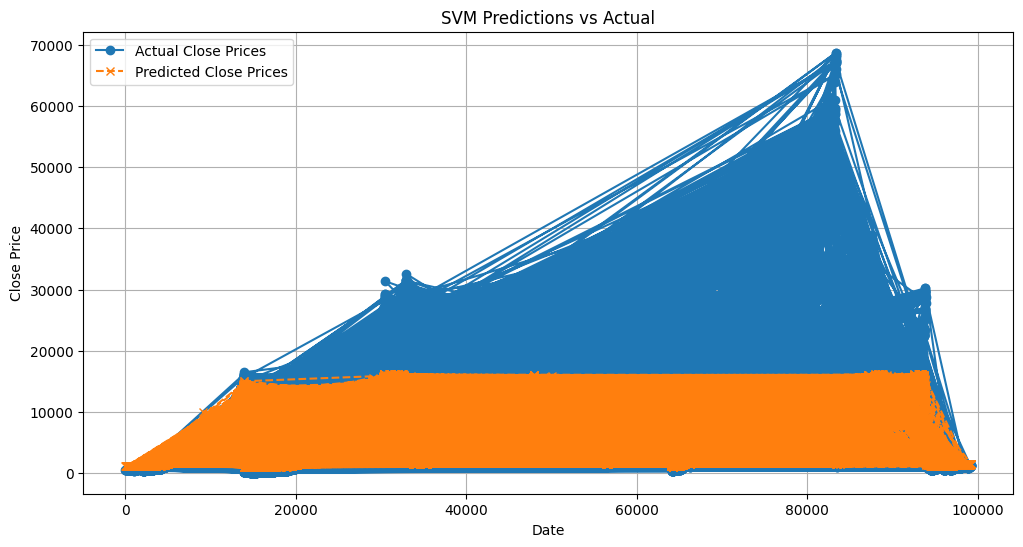

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test, label='Actual Close Prices', marker='o')
plt.plot(y_test.index, y_pred, label='Predicted Close Prices', linestyle='--', marker='x')
plt.title('SVM Predictions vs Actual')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.show()

## Linear Regression

In [21]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Load the cleaned and feature engineered dataset
index_data = pd.read_csv('feature_engineered_data.csv')

# Selecting the features and target variable
X = index_data[['Close_lag_1', 'Close_lag_7', 'Close_lag_30', 'Rolling_Mean_7', 'Rolling_Std_7', 'Daily_Change', 'Significant_High']]
y = index_data['Close']

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Creating and fitting the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Making predictions on the test set
y_pred = model.predict(X_test)

# Evaluating the model using mean squared error
mse = mean_squared_error(y_test, y_pred)
print("MSE:", mse)

# Calculating R^2
r_squared = r2_score(y_test, y_pred)
print("R^2:", r_squared)

MSE: 4.27227355560098e-23
R^2: 1.0


## LR - Model tuning

In [22]:
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import GridSearchCV
import numpy as np

# Ridge Regression
ridge = Ridge()
parameters = {'alpha': np.logspace(-4, 4, 20)}  # Range of alpha values to test
ridge_regressor = GridSearchCV(ridge, parameters, scoring='neg_mean_squared_error', cv=5)
ridge_regressor.fit(X_train, y_train)

# Best parameters and MSE for Ridge
print("Best parameters for Ridge:", ridge_regressor.best_params_)
print("Best MSE for Ridge:", -ridge_regressor.best_score_)

# Lasso Regression
lasso = Lasso()
lasso_regressor = GridSearchCV(lasso, parameters, scoring='neg_mean_squared_error', cv=5)
lasso_regressor.fit(X_train, y_train)

# Best parameters and MSE for Lasso
print("Best parameters for Lasso:", lasso_regressor.best_params_)
print("Best MSE for Lasso:", -lasso_regressor.best_score_)

Best parameters for Ridge: {'alpha': np.float64(0.0001)}
Best MSE for Ridge: 8.7893783768826e-19
Best parameters for Lasso: {'alpha': np.float64(0.0001)}
Best MSE for Lasso: 0.08541256068040613


## LR - Final Evaluation

In [23]:
# Assuming Ridge performed better
final_model = Ridge(alpha=ridge_regressor.best_params_['alpha'])
final_model.fit(X_train, y_train)
final_predictions = final_model.predict(X_test)

# Calculate the mean squared error for the final model
final_mse = mean_squared_error(y_test, final_predictions)
print("Improved RMSE", final_mse)

# Optionally, calculate other metrics like R-squared
final_r_squared = final_model.score(X_test, y_test)
print("R^2:", final_r_squared)

Improved RMSE 4.805262294592823e-18
R^2: 1.0


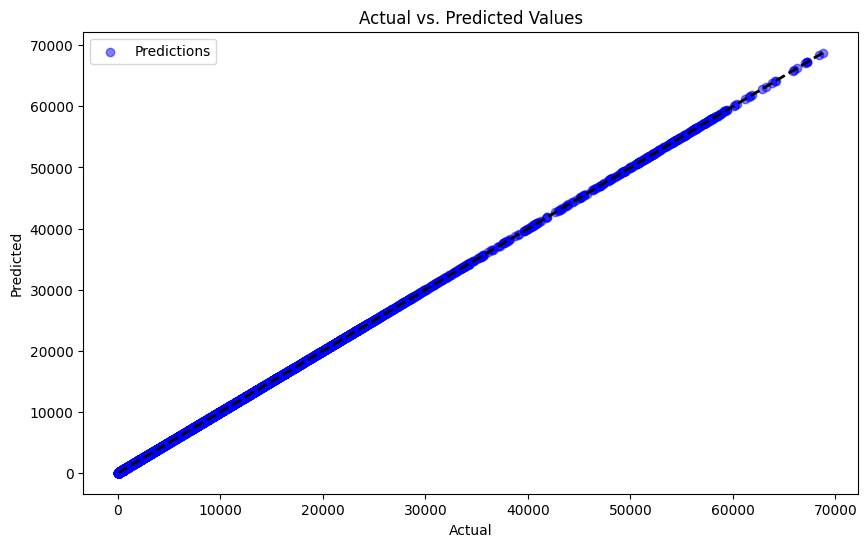

In [24]:
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Assuming data is already loaded and preprocessed
# For demonstration, I'm using an arbitrary alpha value as an example
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
model = Ridge(alpha=1.0)  # Replace 1.0 with the alpha value found via GridSearchCV if applicable
model.fit(X_train, y_train)
predictions = model.predict(X_test)

# Plotting Actual vs Predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, predictions, alpha=0.5, color='blue', label='Predictions')  # Adjust color if needed
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)  # Ideal prediction line
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs. Predicted Values')
plt.legend()
plt.show()